# Task
---

# 1) 
    Aus dem NearLab-Datensatz die Dateien "Basic Movements" für eine Person herunterladen. Es müsste drei Dateien pro Person geben.
# 2) 
    Ein Netzwerk in pytorch erstellen, dass die Architektur aus dem Paper reproduziert (also drei convolutional layer, dann drei fully connected layer)
# 3)
    Das Netzwerk mti zwei von drei Dateien trainieren und auf der letzten Datei evaluieren. 

--- 

# Summary - Paper

## Introduction 

- Challenges of using EMG signals for smooth control: 
    1. Detect the exact hand movement 
    2. Choosing the right combination of features
    3. Having enough data (since we are working with a DNN)
- 8 basic movements and 6 combined movements

# Movements
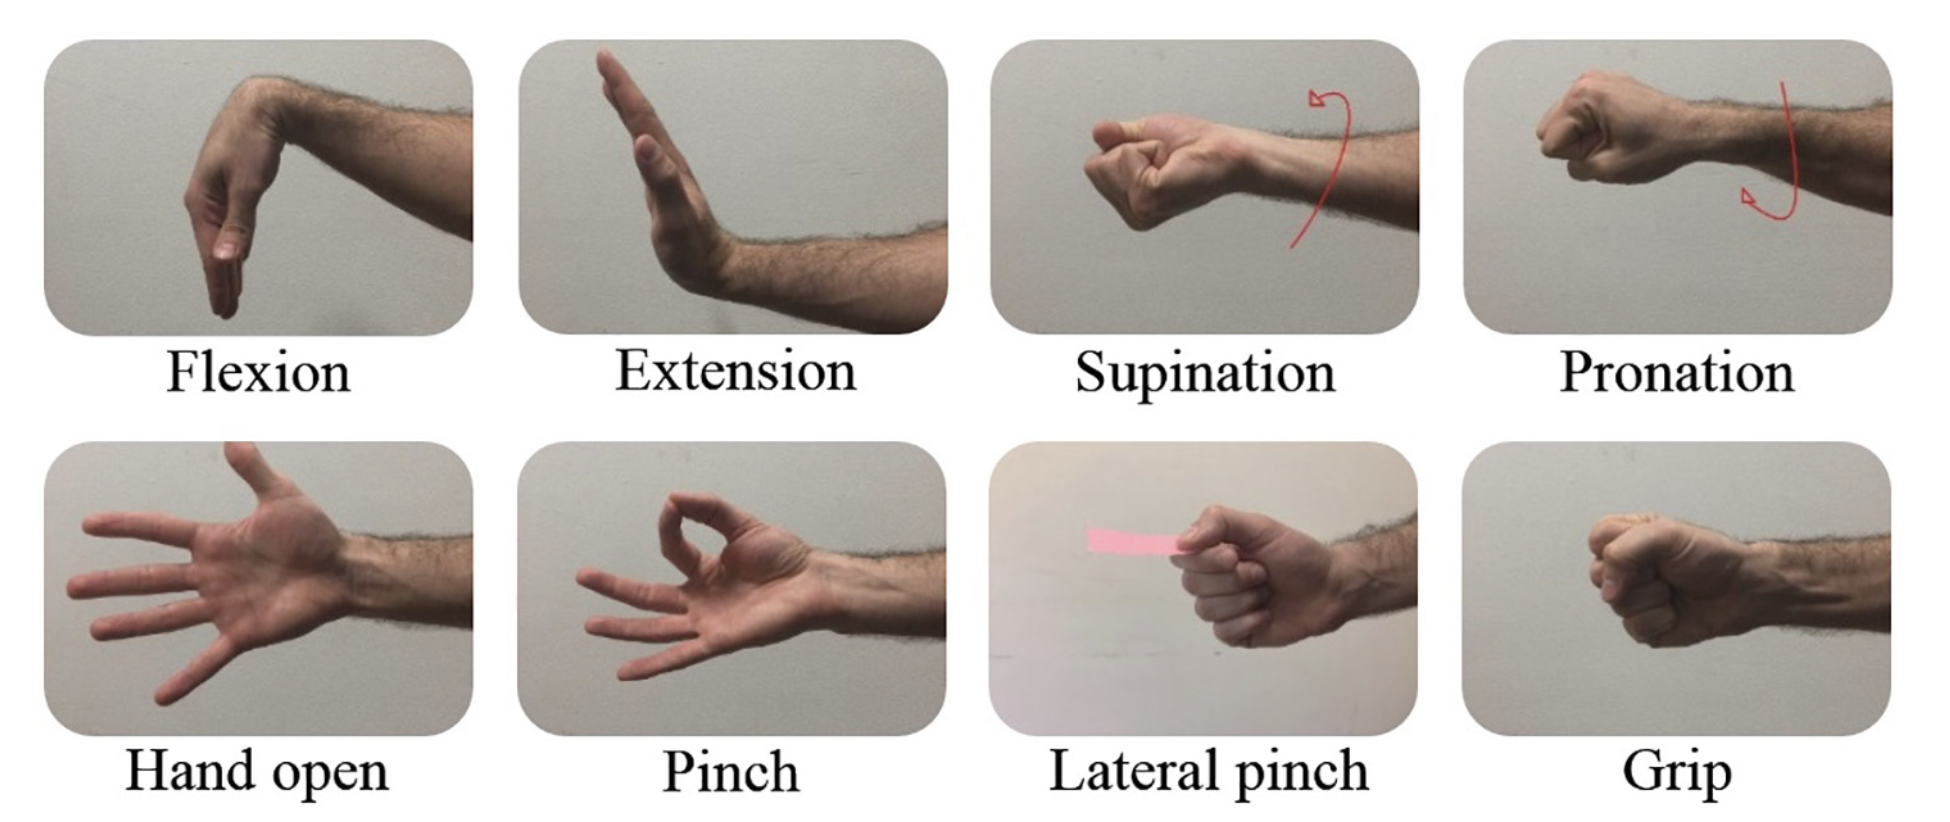

## Preprocessing

- 3/5 of each movements repetitions were added to the training set, remaining in test set
- 15 time and frequency features were used to create 4 feature sets
- Outlier removal and scaling using mean and standard deviation 
- Classifiers
    - K-Nearest Neighbours with 40 neighbours and Euclidian distance metric 
    - Support Vector Machines with linear kernel and regularization parameter equal to one 
    - Multilayer Perceptron with 300 neurons in the single hidden layer, tanh as activation function and 0.00001 learning rate
    - LDA (Linear Discriminant Analysis) as reference classifiers

## Deep Learning methods

- Two baseline CNNs are proposed in the article and both can be divided into 2 parts
- First part is an inter-connected network of convolutional blocks working as a "feature extractor" and the second part consists of few fully connected layers serving as the "classfier"
- Implemented using Keras (We will do it in pytorch)
- Each classifier’s inputs are configured as a 10 × 512 matrix (number of channels × data points in one window)
- Activation function is randomized rectified linear unit (RReLU)
- Dropout with (just going to use) 0.3 are eliminated from hidden layers
- Batch Normalization (BN) was aimed to solve the need for low learning rate and careful parameter init. in the training of the DNN 

## Deep learning architecture 1: Cnet2D

- 3 consecutive conv. blocks constructing the feature extractor part
- followed by 2 fully connected blocks as the classifiers part 
- ully connected blocks as the classifier part (Figure 3). Each convolutional block consists of a convolution layer with a 2D filter shape, BN, RReLU activation layer, max-pooling, and dropout
- Filter sizes of convolutional layers are (3,13), (3,9), (3,5), respectively
- The first fully connected block includes a dense layer, BN, RReLU, and dropout, while the second fully connected block does not include dropout
- In the end, a Softmax layer is added to create the output of the classifier
- Adam optimizer is being used as an optimization method
- During training, the model with minimum validation loss (20% of training data is randomly selected as validation set) is saved and used for testing

## Deep learning architecture 2: Cnet1D

- similar to Cnet2D
- filter’s shape is such that it does not exploit the relations between channels in the feature extraction part
- Filter sizes of convolutional layers are (1,13), (1,9), (1,5), respectively
- max-pooling layer parameters are selected differently
- The max-pooling size for Nearlab is (1,4), while for Ninapro is (1,3)

## Learning Parameters

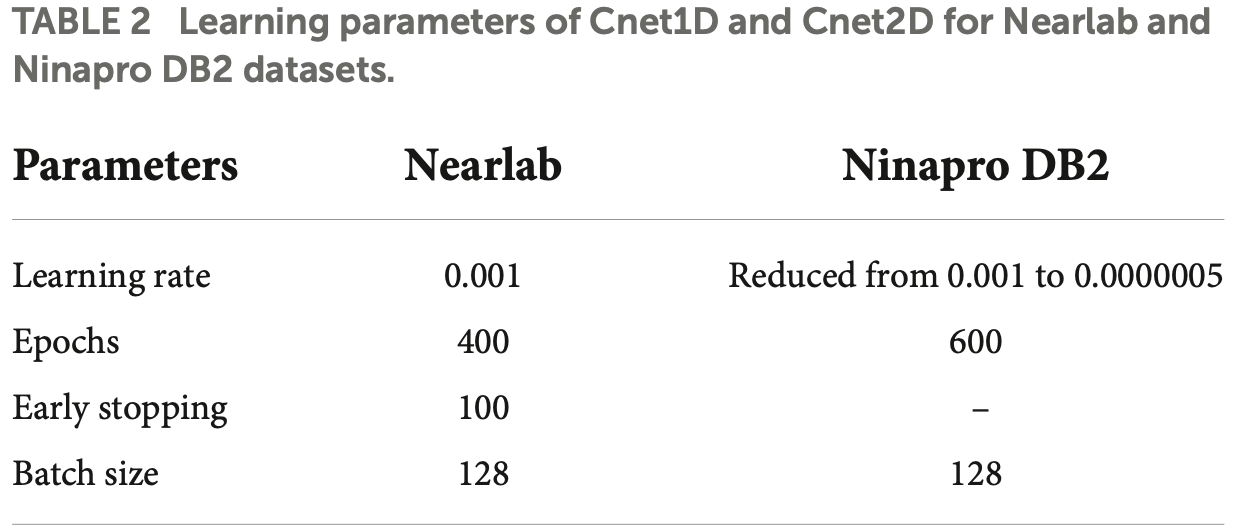



# Implementation: 

# Reading in the File

Brief Description: Nearlab dataset is a sEMG hand/wrist movement dataset, which
includes 8 basic movements along with their combinations (6 combined
movements), acquired from 11 subjects. Nearlab dataset is specifically useful to
investigate sEMG data transferability 1. between complex movements and their
associated basic movements 2. between subjects. It is our hope that this dataset
will become a useful tool to compare different task-transfer strategies. Moreover,
by considering 3 hand orientations when executing each hand gesture, EMG
variability due to starting hand orientation was accounted for in this database.

### Data format: Data is available in .csv format.
#### Basic movement data:

- Each row is one window (512 sample) extracted from the movements performed in a round. The segments are shuffled. 
- Each row has 5122 columns (512 samples*10 channels+ 2). The first 5120 is related to 512 samples of 10 channels of EMG sensors (first 512 samples for the first channel then second and so on).
- Column 5121 shows label of movement class related to that segment (1 Flexion, 2 Extension, 3 Supination, 4 Pronation, 5 Open, 6 Pinch, 7 Lateral pinch, 8 Fist).
- Column 5122 shows which movement number (out of 40) this row belongs to. (In each round subject performs 5 repetitions of each of the 8 movements, so each round includes 40 movements.) 

- To clarify why this labeling is important please consider the following example:

    For example, window one could be related to class 1 and movement 20 and window
    ten could be related to class 1 but movement 32. Hence, although these segments
    are related to same class but are not from the same repetition of the movement.
    When we want to separate the repetitions of one class to generate train and test
    subsets, it is important to include all segments of the same repetition in one subset
    and do not distribute the segments related to class 1 movement 32 into train and
    test subsets. Otherwise, the classifier will be trained and tested on the same
    repetition and falsely indicate generalizability. The last column providing
    movement number helps the user to separate the shuffled data in the correct
    format.

## Imports
---

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Preprocessing
---

In [16]:
# Preprocessing step (we are going to skip the outlier removal and only use standardization)
def preprocess(X):
    # Reshape X to (n_samples, n_channels, n_timepoints) for more information look into next illustration
    X = X.reshape(-1, 10, 512)
    # Standardization (Z-Score Normalization in this case)
    standard = StandardScaler()
    # Scales each channel independently from each other
    X = np.array([standard.fit_transform(channel.T).T for channel in X])
    
    return X

# Transforms the data into tensors
def to_tensors(X, y):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

# Reads in the first 2 files as training data and the last as test set
def load_data(file_paths):
    X_train_list, y_train_list = [], []
    
    # Load the training data
    for train_file in file_paths[:2]:
        data = pd.read_csv(train_file, header=None, skiprows=[0])
        # Input Values
        X = data.iloc[:, :5120].values
        # Class
        y = data.iloc[:, 5120].values
        y = y - 1
        X = preprocess(X)
        X_train_list.append(X)
        y_train_list.append(y)
    
    # Combine the trainingsdata
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    
    # Load the test data
    data = pd.read_csv(file_paths[2], header=None, skiprows=[0])
    X_test = data.iloc[:, :5120].values # Values
    y_test = data.iloc[:, 5120].values  # Class
    y_test = y_test - 1
    X_test = preprocess(X_test)
    
    # Convert into pytorch tensors for the model
    X_train, y_train = to_tensors(X_train, y_train)
    X_test, y_test = to_tensors(X_test, y_test)
    
    return X_train, y_train, X_test, y_test

# Local Files (Create a data folder or change the path to use it please). 
# You can find the data here:
files = ["data/Nearlab_sbj1_WL512_S128_r1.csv", "data/Nearlab_sbj1_WL512_S128_r2.csv", "data/Nearlab_sbj1_WL512_S128_r3.csv"]

X_train, y_train, X_test, y_test = load_data(files)

# Model 
---

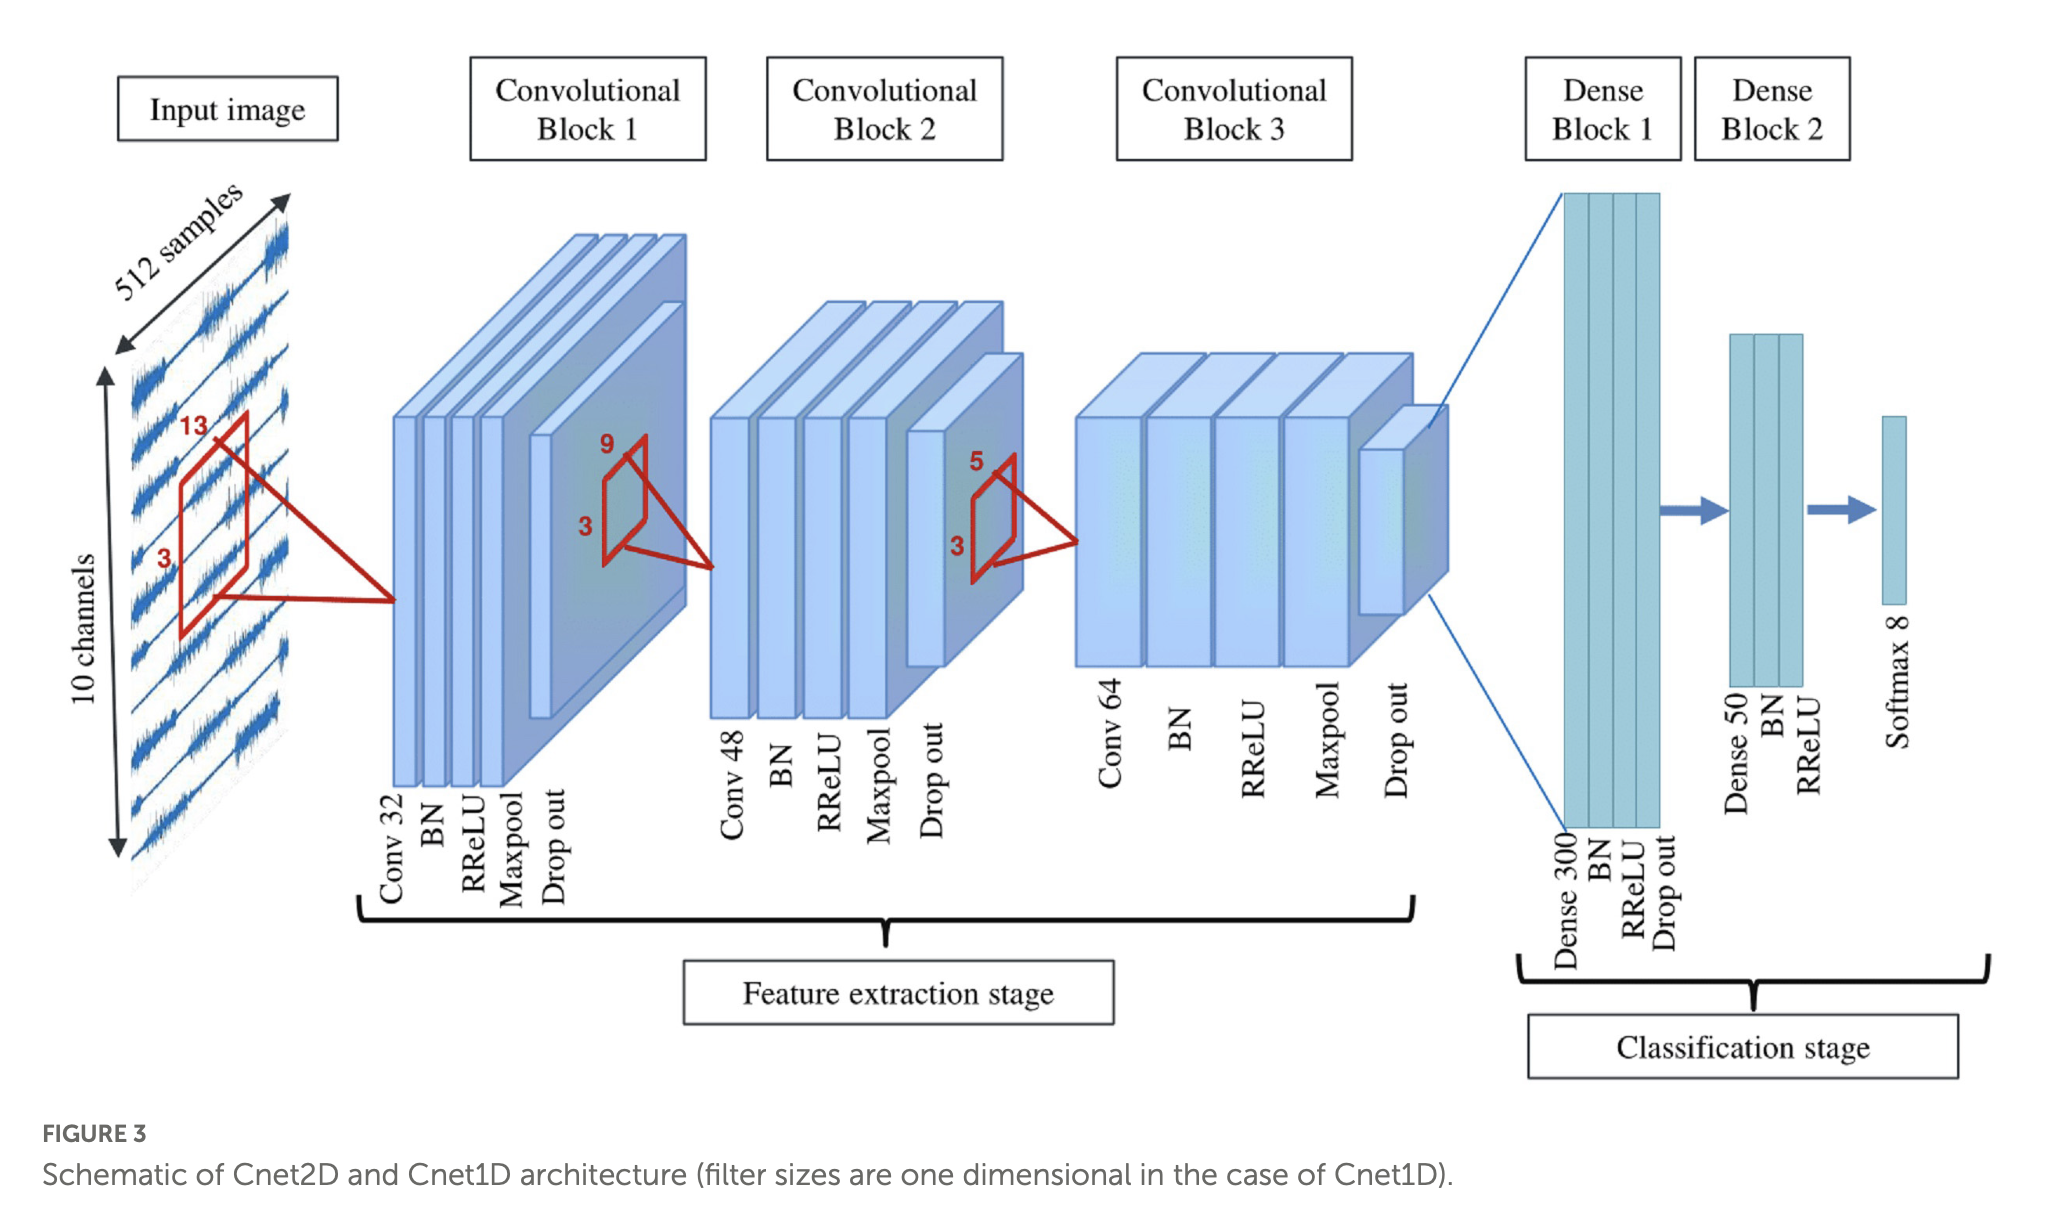

In [17]:
class CNet2D(nn.Module):
    def __init__(self):
        super(CNet2D, self).__init__()
        
        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 13), padding=(1, 6))
        self.bn1 = nn.BatchNorm2d(32)
        self.rrelu1 = nn.RReLU()
        self.drop1 = nn.Dropout(0.3)
        
        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 48, kernel_size=(3, 9), padding=(1, 4))
        self.bn2 = nn.BatchNorm2d(48)
        self.rrelu2 = nn.RReLU()
        self.drop2 = nn.Dropout(0.3)
        
        # Conv Block 3
        self.conv3 = nn.Conv2d(48, 64, kernel_size=(3, 5), padding=(1, 2))
        self.bn3 = nn.BatchNorm2d(64)
        self.rrelu3 = nn.RReLU()
        self.drop3 = nn.Dropout(0.3)
        
        # Dense Block 1
        self.fc1 = nn.Linear(64 * 10 * 64, 300)
        self.fc_bn1 = nn.BatchNorm1d(300)
        self.fc_rrelu1 = nn.RReLU()
        self.fc_drop1 = nn.Dropout(0.3)
        
        # Dense Block 2 
        self.fc2 = nn.Linear(300, 50)
        self.fc_bn2 = nn.BatchNorm1d(50)
        self.fc_rrelu2 = nn.RReLU()
        
        # Softmax Layer for classification
        self.fc3 = nn.Linear(50, 8)
        
    def forward(self, x):
        x = self.rrelu1(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, (1, 2))
        x = self.drop1(x)
        
        x = self.rrelu2(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, (1, 2))
        x = self.drop2(x)
        
        x = self.rrelu3(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, (1, 2))
        x = self.drop3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc_rrelu1(self.fc_bn1(self.fc1(x)))
        x = self.fc_drop1(x)
        
        x = self.fc_rrelu2(self.fc_bn2(self.fc2(x)))
        
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

# Training
---

__Since i was not really familiar with the syntax and practice of pytorch, I used the following page as a help:__
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [18]:
# Reshape data
def reshape_data(X):
    return X.reshape(X.shape[0], 1, -1, X.shape[-1])

X_train = reshape_data(X_train)
X_test = reshape_data(X_test)

# Hyperparameter
batch_size = 128
epochs = 5
learning_rate = 0.001

# Create a Tensor dataset for the training of the data
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Init model, loss function and optimizer
model = CNet2D()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_epoch = []

# Training
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Reset Gradient
        optimizer.zero_grad()
        # Forward Pass
        outputs = model(batch_X)
        # Comp loss
        loss = loss_func(outputs, batch_y)
        loss_epoch.append(loss)
        # Backward step
        loss.backward()
        # Update weights for ADAM
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}')
    

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


# Plotting
---

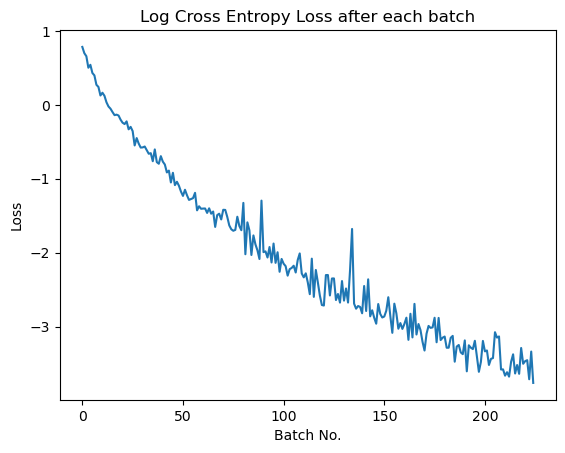

In [23]:
plt.plot([np.log(loss.item()) for loss in loss_epoch])
plt.title("Log Cross Entropy Loss after each batch")
plt.xlabel("Batch No.")
plt.ylabel("Loss")
plt.show()

# Testing 
---

In [24]:
# Eval mode
model.eval()
# Turn off gradient caluclation
with torch.no_grad():
    # Forward pass with train data
    outputs = model(X_test)
    # Get predicted values
    _, predicted = torch.max(outputs, 1)
    # Calc accuracy by taking mean over 0 and 1 values
    accuracy = (predicted == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item():.6f}')

Test Accuracy: 0.868295


90,55% Accuracy